# Import Dependencies

In [1]:
# from utils import * # backend file
# from dotenv import load_dotenv # load config
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.covariance import ShrunkCovariance,\
	empirical_covariance, log_likelihood
from scipy import linalg
from sklearn.model_selection import GridSearchCV
import random
from sklearn.preprocessing import QuantileTransformer
from pypfopt import black_litterman, risk_models, \
    BlackLittermanModel, plotting, DiscreteAllocation, \
    EfficientFrontier, objective_functions
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from joblib import dump, load
from scipy.stats import linregress
from scipy.optimize import minimize
import yfinance as yf
import pandas as pd
import numpy as np

In [2]:
# load_dotenv()

In [3]:
# username = int(os.getenv('MT5_USERNAME'))
# password = os.getenv('MT5_PASSWORD')
# server = os.getenv('MT5_SERVER')
# api_key = os.getenv('BINANCE_API')
# api_secret = os.getenv('BINANCE_SECRET_API')

In [4]:
# datafetcher = DataFetcher(username, password, server, api_key, api_secret)
# dataprocessor = DataProcessor()

In [5]:
# datafetcher.get_investor_data()

# Instruments List

In [6]:
tickers_dict = {
    "bond_etfs": ["MUB", "BND", "SCHZ", "GOVT", "SPIB", "BSV","TIP","VCSH"], 
    "stock_etfs": ["PFF", "SCHD", "IYR", "SDY","DGRO","VOO"],
    "cash_equivalents": ['SHV', 'BIL']
}

# Historical Bars

In [7]:
def yfinance_adj_close(tickers, start=None, end=None, period='1mo', interval='1d'):
    if isinstance(tickers, str):
        tickers = [tickers]

    try:
        if start and end:
            print(f"Fetching data for {tickers} from {start} to {end} with interval '{interval}'")
            data = yf.download(tickers, start=start, end=end, interval=interval)
        else:
            print(f"Fetching data for {tickers} with period '{period}' and interval '{interval}'")
            data = yf.download(tickers, period=period, interval=interval)
        
        if "Adj Close" in data.columns:
            return data["Adj Close"]
        else:
            print("Warning: 'Adj Close' data not available, returning full dataset.")
        return data
    except Exception as e:
        print(f"Error while fetching data: {e}")
        return None

In [8]:
all_data = {}
start_date = '2019-01-01'
end_date = '2024-01-01'

for category, tickers in tickers_dict.items():
    print(f"Fetching data for category: {category}")
    all_data[category] = yfinance_adj_close(tickers, start=start_date, end=end_date)

df = pd.concat(all_data.values(), axis=1)
df.ffill(inplace=True)
df.bfill(inplace=True)
df

Fetching data for category: bond_etfs
Fetching data for ['MUB', 'BND', 'SCHZ', 'GOVT', 'SPIB', 'BSV', 'TIP', 'VCSH'] from 2019-01-01 to 2024-01-01 with interval '1d'


[*********************100%%**********************]  8 of 8 completed


Fetching data for category: stock_etfs
Fetching data for ['PFF', 'SCHD', 'IYR', 'SDY', 'DGRO', 'VOO'] from 2019-01-01 to 2024-01-01 with interval '1d'


[*********************100%%**********************]  6 of 6 completed


Fetching data for category: cash_equivalents
Fetching data for ['SHV', 'BIL'] from 2019-01-01 to 2024-01-01 with interval '1d'


[*********************100%%**********************]  2 of 2 completed


Ticker,BND,BSV,GOVT,MUB,SCHZ,SPIB,TIP,VCSH,DGRO,IYR,PFF,SCHD,SDY,VOO,BIL,SHV
Date,,,,,,,,,,,,,,,,
2019-01-02,67.512169,69.351891,21.959671,94.844879,19.824820,27.773350,90.961281,66.630157,28.828924,62.579842,25.145708,14.611280,76.505974,209.174637,80.134125,96.215034
2019-01-03,67.775902,69.510643,22.083395,95.114571,19.903009,27.848934,91.492065,66.758301,28.149986,62.981014,25.189381,14.325091,75.542328,204.181534,80.160393,96.249924
2019-01-04,67.571732,69.334251,21.968512,94.862267,19.828730,27.773350,91.301323,66.578896,28.985600,63.655277,25.458664,14.720157,77.297523,210.920883,80.169189,96.276085
2019-01-07,67.469650,69.254852,21.924334,94.853546,19.813093,27.756554,91.243271,66.553299,29.107460,64.295418,25.538731,14.819702,77.607262,212.503387,80.169189,96.276085
2019-01-08,67.384605,69.193169,21.880150,94.783951,19.813093,27.756554,91.317894,66.519119,29.359892,65.464737,25.604223,14.959688,78.570892,214.567917,80.169189,96.267349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,70.975830,74.551132,22.327000,105.372810,22.082460,31.432365,104.905853,74.429260,52.629528,89.244858,29.518307,25.087961,122.029755,431.015472,87.204689,105.034912
2023-12-26,71.043549,74.502655,22.346432,105.411736,22.106207,31.441975,104.964439,74.429260,52.885155,89.923187,29.537209,25.210342,122.638824,432.807709,87.223793,105.053993
2023-12-27,71.498276,74.696587,22.472742,105.839890,22.243956,31.586029,105.442970,74.583580,52.963806,90.395073,29.678989,25.230186,122.864761,433.599792,87.223793,105.053993


## Historical Market Cap

In [9]:
all_caps = {}
start_date = '2019-01-01'
end_date = '2024-01-01'

for category, tickers in tickers_dict.items():
    if category == 'cash_equivalents':
        continue
    
    print(f"Fetching marketCap data for category: {category}")
    market_caps = {}
    
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date)
        
        outstanding_shares = stock.info.get('sharesOutstanding', None)
        
        if outstanding_shares is not None:
            market_cap_series = data['Close'] * outstanding_shares
            market_caps[ticker] = market_cap_series
        else:
            print(f"Warning: {ticker} has no outstanding shares data.")
            market_caps[ticker] = pd.Series([None] * len(data), index=data.index)
    
    all_caps[category] = pd.DataFrame(market_caps)

caps = pd.concat(all_caps.values(), axis=1)
caps.ffill(inplace=True)
caps.bfill(inplace=True)
caps

Fetching marketCap data for category: bond_etfs
Fetching marketCap data for category: stock_etfs


,MUB,BND,SCHZ,GOVT,SPIB,BSV,TIP,VCSH,PFF,SCHD,IYR,SDY,DGRO,VOO
Date,,,,,,,,,,,,,,
2019-01-02 00:00:00-05:00,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2019-01-03 00:00:00-05:00,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2019-01-04 00:00:00-05:00,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2019-01-07 00:00:00-05:00,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2019-01-08 00:00:00-05:00,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2023-12-26 00:00:00-05:00,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2023-12-27 00:00:00-05:00,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [10]:
caps_dict = {'MUB': 30.6e9, 
    'BND': 89e9,
    'SCHZ': 10.6e9,
    'GOVT': 20.1e9,
    'SPIB': 15.3e9,
    'BSV': 50e9,
    'TIP': 25.9e9,
    'VCSH': 47e9,
    'PFF': 12e9,
    'SCHD': 47e9,
    'IYR': 3.8e9,
    'SDY': 22.6e9,
    'DGRO': 24e9,
    'VOO': 317e9}
caps_dict

{'MUB': 30600000000.0,
 'BND': 89000000000.0,
 'SCHZ': 10600000000.0,
 'GOVT': 20100000000.0,
 'SPIB': 15300000000.0,
 'BSV': 50000000000.0,
 'TIP': 25900000000.0,
 'VCSH': 47000000000.0,
 'PFF': 12000000000.0,
 'SCHD': 47000000000.0,
 'IYR': 3800000000.0,
 'SDY': 22600000000.0,
 'DGRO': 24000000000.0,
 'VOO': 317000000000.0}

In [11]:
ticker = "^IRX"

start_date = "2019-01-01"
end_date = "2024-01-01"

rf = yf.download(ticker, start=start_date, end=end_date)
rf = rf[['Adj Close']]
rf = rf.rename(columns={'Adj Close': 'rf'})
rf

[*********************100%%**********************]  1 of 1 completed


,rf
Date,
2019-01-02,2.365
2019-01-03,2.355
2019-01-04,2.358
2019-01-07,2.353
2019-01-08,2.400
...,...
2023-12-22,5.208
2023-12-26,5.203
2023-12-27,5.235


In [12]:
rolling_rf = rf.rolling(window=252).mean()
rolling_rf

,rf
Date,
2019-01-02,NaN
2019-01-03,NaN
2019-01-04,NaN
2019-01-07,NaN
2019-01-08,NaN
...,...
2023-12-22,5.023583
2023-12-26,5.027532
2023-12-27,5.031667


# Asset Allocation

## VCV Estimation

In [13]:
selected_tickers = tickers_dict['bond_etfs'] + tickers_dict['stock_etfs']

filtered_df = df[selected_tickers]
filtered_df

Ticker,MUB,BND,SCHZ,GOVT,SPIB,BSV,TIP,VCSH,PFF,SCHD,IYR,SDY,DGRO,VOO
Date,,,,,,,,,,,,,,
2019-01-02,94.844879,67.512169,19.824820,21.959671,27.773350,69.351891,90.961281,66.630157,25.145708,14.611280,62.579842,76.505974,28.828924,209.174637
2019-01-03,95.114571,67.775902,19.903009,22.083395,27.848934,69.510643,91.492065,66.758301,25.189381,14.325091,62.981014,75.542328,28.149986,204.181534
2019-01-04,94.862267,67.571732,19.828730,21.968512,27.773350,69.334251,91.301323,66.578896,25.458664,14.720157,63.655277,77.297523,28.985600,210.920883
2019-01-07,94.853546,67.469650,19.813093,21.924334,27.756554,69.254852,91.243271,66.553299,25.538731,14.819702,64.295418,77.607262,29.107460,212.503387
2019-01-08,94.783951,67.384605,19.813093,21.880150,27.756554,69.193169,91.317894,66.519119,25.604223,14.959688,65.464737,78.570892,29.359892,214.567917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,105.372810,70.975830,22.082460,22.327000,31.432365,74.551132,104.905853,74.429260,29.518307,25.087961,89.244858,122.029755,52.629528,431.015472
2023-12-26,105.411736,71.043549,22.106207,22.346432,31.441975,74.502655,104.964439,74.429260,29.537209,25.210342,89.923187,122.638824,52.885155,432.807709
2023-12-27,105.839890,71.498276,22.243956,22.472742,31.586029,74.696587,105.442970,74.583580,29.678989,25.230186,90.395073,122.864761,52.963806,433.599792


In [14]:
def return_from_prices(prices, log_returns = False):
    if log_returns:
        returns = np.log(1 + prices.pct_change()).dropna(how = 'all')
    else:
        returns = prices.pct_change().dropna(how = 'all')
    return returns

In [15]:
log_returns = return_from_prices(filtered_df, log_returns=True)
log_returns.dropna(inplace=True)
log_returns

Ticker,MUB,BND,SCHZ,GOVT,SPIB,BSV,TIP,VCSH,PFF,SCHD,IYR,SDY,DGRO,VOO
Date,,,,,,,,,,,,,,
2019-01-03,0.002839,0.003899,0.003936,0.005618,0.002718,0.002286,0.005818,0.001921,0.001735,-0.019781,0.006390,-0.012676,-0.023832,-0.024160
2019-01-04,-0.002656,-0.003017,-0.003739,-0.005216,-0.002718,-0.002541,-0.002087,-0.002691,0.010634,0.027205,0.010649,0.022969,0.029252,0.032474
2019-01-07,-0.000092,-0.001512,-0.000789,-0.002013,-0.000605,-0.001146,-0.000636,-0.000385,0.003140,0.006740,0.010006,0.003999,0.004195,0.007475
2019-01-08,-0.000734,-0.001261,0.000000,-0.002017,0.000000,-0.000891,0.000818,-0.000514,0.002561,0.009402,0.018023,0.012340,0.008635,0.009668
2019-01-09,-0.001102,0.001388,-0.000198,0.000000,0.002418,0.000891,0.001180,0.002181,-0.001992,0.000831,-0.001305,0.001313,0.002665,0.004610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.000831,-0.000668,-0.000645,-0.000870,0.000611,0.000715,-0.001953,0.000532,0.001282,0.006083,0.003310,0.004114,0.003368,0.002323
2023-12-26,0.000369,0.000954,0.001075,0.000870,0.000306,-0.000650,0.000558,0.000000,0.000640,0.004866,0.007572,0.004979,0.004845,0.004150
2023-12-27,0.004054,0.006380,0.006212,0.005636,0.004571,0.002600,0.004549,0.002071,0.004789,0.000787,0.005234,0.001841,0.001486,0.001828


### Scaling

In [ ]:
scaler = QuantileTransformer(output_distribution='uniform')
scaled_df = pd.DataFrame(scaler.fit_transform(filtered_df), columns=filtered_df.columns, index=filtered_df.index)

print(scaled_df)

Ticker           MUB       BND      SCHZ      GOVT      SPIB       BSV  \
Date                                                                     
2019-01-02  0.011840  0.084084  0.014319  0.208738  0.004004  0.007752   
2019-01-03  0.019056  0.108188  0.025071  0.260247  0.007007  0.014247   
2019-01-04  0.014073  0.087833  0.015338  0.215461  0.004004  0.005005   
2019-01-07  0.013013  0.080252  0.009009  0.190157  0.002002  0.001001   
2019-01-08  0.005306  0.071280  0.009009  0.171672  0.002002  0.000000   
...              ...       ...       ...       ...       ...       ...   
2023-12-22  0.741634  0.425025  0.579811  0.342666  0.640973  0.630568   
2023-12-26  0.744728  0.427882  0.586224  0.349850  0.642176  0.626745   
2023-12-27  0.771734  0.452416  0.599609  0.384347  0.657488  0.640281   
2023-12-28  0.757270  0.440364  0.595250  0.371409  0.656325  0.636927   
2023-12-29  0.750269  0.433089  0.592670  0.360371  0.655239  0.639623   

Ticker           TIP      VCSH       

In [17]:
base_X_train = scaled_df.loc[:'2021-01-01']
base_X_test = scaled_df.loc['2021-01-01':]

In [18]:
noOfFeatures, noOfSamples = 14, 1489
np.random.seed(42)

colorMatrix = np.random.randn(noOfFeatures, noOfFeatures)
X_train = np.dot(base_X_train, colorMatrix)
X_test = np.dot(base_X_test, colorMatrix)

In [19]:
# defining a Spanning range of all possible shrinkage coefficient values
shrinkageFactor = np.logspace(-2, 0, 32)
negative_logliks = [
	-ShrunkCovariance(shrinkage=s).fit(X_train).score(X_test)\
for s in shrinkageFactor]
realCovariance = np.dot(colorMatrix.T, colorMatrix)
empiricalCovariance = empirical_covariance(X_train)
logRealLikelihood = - \
	log_likelihood(empiricalCovariance, linalg.inv(realCovariance))

# GridSearch method for an optimal shrinkage coefficient
tunedParameters = [{"shrinkage": shrinkageFactor}]
cv = GridSearchCV(ShrunkCovariance(), tunedParameters)
cv.fit(X_train)

GridSearchCV(estimator=ShrunkCovariance(),
             param_grid=[{'shrinkage': array([0.01      , 0.01160155, 0.0134596 , 0.01561523, 0.01811609,
       0.02101748, 0.02438354, 0.02828869, 0.03281928, 0.03807546,
       0.04417345, 0.05124806, 0.05945571, 0.06897785, 0.08002502,
       0.09284145, 0.10771051, 0.12496091, 0.14497407, 0.16819243,
       0.19512934, 0.22638034, 0.26263635, 0.30469896, 0.35349811,
       0.41011271, 0.47579443, 0.55199543, 0.64040043, 0.74296395,
       0.86195357, 1.        ])}])

In [20]:
optimal_shrinkage_coef = cv.best_estimator_.shrinkage
optimal_shrinkage_coef

0.02438354098268829

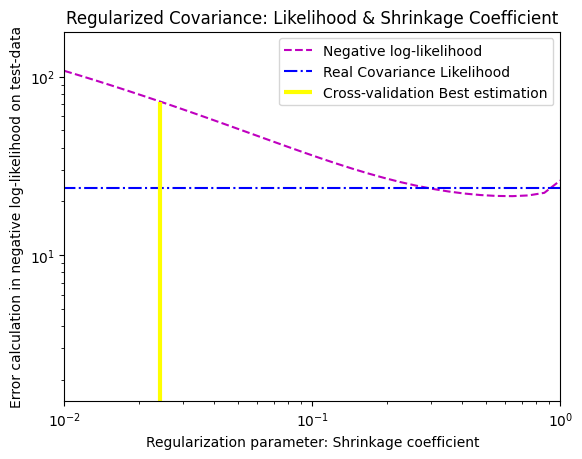

In [21]:
# defining range of shrinkage curve
plt.loglog(shrinkageFactor,
		negative_logliks,
		"m--",
		label="Negative log-likelihood")

plt.plot(plt.xlim(),
		2 * [logRealLikelihood],
		"b-.",
		label="Real Covariance Likelihood")

# Adjusting View in Graph
maxLikelihood = np.amax(negative_logliks)
minLikelihood = np.amin(negative_logliks)
min_y = minLikelihood - 7.0 * np.log((plt.ylim()[1] - plt.ylim()[0]))
max_y = maxLikelihood + 16.0 * np.log(maxLikelihood - minLikelihood)
min_x = shrinkageFactor[0]
max_x = shrinkageFactor[-1]

# Best Covariance estimator likelihood
plt.vlines(
	cv.best_estimator_.shrinkage, min_y,
	-cv.best_estimator_.score(X_test),
	color="yellow",
	linewidth=3,
	label="Cross-validation Best estimation",
)
#plotting in Graph
plt.title("Regularized Covariance: Likelihood & Shrinkage Coefficient")
plt.xlabel("Regularization parameter: Shrinkage coefficient")
plt.ylabel("Error calculation in negative log-likelihood on test-data")
plt.ylim(min_y, max_y)
plt.xlim(min_x, max_x)
plt.legend()
plt.show()

In [22]:
from pypfopt.risk_models import CovarianceShrinkage

class CustomCovarianceShrinkage(CovarianceShrinkage):
    def shrunk_covariance(self, delta=0.2):
        return super().shrunk_covariance(delta=optimal_shrinkage_coef)
    
cov_matrix = CustomCovarianceShrinkage(log_returns, True, 252, True).ledoit_wolf()
cov_matrix

Ticker,MUB,BND,SCHZ,GOVT,SPIB,BSV,TIP,VCSH,PFF,SCHD,IYR,SDY,DGRO,VOO
Ticker,,,,,,,,,,,,,,
MUB,0.004200,0.002679,0.002626,0.001423,0.002490,0.000963,0.001600,0.001882,0.006304,0.003565,0.006454,0.003898,0.004058,0.004333
BND,0.002679,0.004993,0.004215,0.003183,0.003038,0.001379,0.003278,0.001896,0.004386,0.001588,0.004599,0.001729,0.002044,0.002580
SCHZ,0.002626,0.004215,0.004918,0.003274,0.002878,0.001390,0.003327,0.001858,0.004679,0.001204,0.004390,0.001525,0.001608,0.002181
GOVT,0.001423,0.003183,0.003274,0.004123,0.002076,0.001257,0.003038,0.001224,0.000703,-0.002862,-0.000347,-0.002724,-0.002636,-0.002225
SPIB,0.002490,0.003038,0.002878,0.002076,0.003839,0.001293,0.002380,0.002255,0.004093,0.003040,0.005691,0.003004,0.003367,0.003875
BSV,0.000963,0.001379,0.001390,0.001257,0.001293,0.001325,0.001287,0.000992,0.001085,0.000164,0.001420,0.000205,0.000297,0.000504
TIP,0.001600,0.003278,0.003327,0.003038,0.002380,0.001287,0.005419,0.001503,0.003044,0.000017,0.003065,0.000268,0.000460,0.001084
VCSH,0.001882,0.001896,0.001858,0.001224,0.002255,0.000992,0.001503,0.002387,0.003183,0.002375,0.004323,0.002354,0.002561,0.002918
PFF,0.006304,0.004386,0.004679,0.000703,0.004093,0.001085,0.003044,0.003183,0.028667,0.020612,0.028947,0.023000,0.022781,0.024097


## Black-Litterman Approach

In [23]:
target_prices = pd.read_excel(r"C:\Users\HP\Downloads\target_price.xlsx", sheet_name="Sheet1", index_col=0)
target_prices = target_prices[['Target Price']]
columns_to_select = filtered_df.columns
target_prices = target_prices[target_prices.index.isin(columns_to_select)]
target_series = target_prices['Target Price']
target_series

Ticker
MUB     109.52
BND      77.67
SCHZ     48.95
GOVT     24.75
SPIB     34.69
BSV      79.24
TIP     117.10
VCSH     79.69
PFF      31.15
SCHD     83.17
IYR      73.53
SDY     122.40
DGRO     59.96
VOO     538.60
Name: Target Price, dtype: float64

In [24]:
start_date = '2019-01-01'
end_date = '2024-01-01'

market_prices = yf.download("SPY", start=start_date, end=end_date)["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
2019-01-02    228.403656
2019-01-03    222.953323
2019-01-04    230.421295
2019-01-07    232.238083
2019-01-08    234.419998
Name: Adj Close, dtype: float64

In [25]:
market_prices.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1258 entries, 2019-01-02 to 2023-12-29
Series name: Adj Close
Non-Null Count  Dtype  
--------------  -----  
1258 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB


In [26]:
S = cov_matrix
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

3.3397697460852998

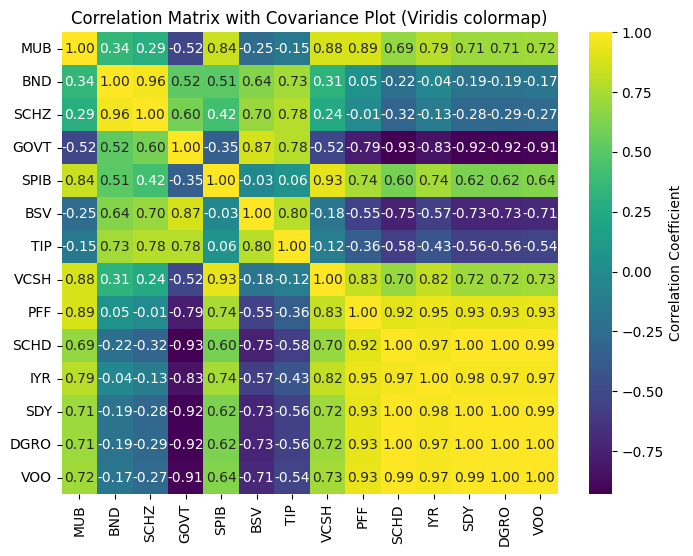

In [27]:
corr_matrix = np.corrcoef(S)

plt.figure(figsize=(8, 6))

sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f', 
            xticklabels=S.columns, yticklabels=S.columns,
            cbar_kws={'label': 'Correlation Coefficient'});

plt.title("Correlation Matrix with Covariance Plot (Viridis colormap)")
plt.show()

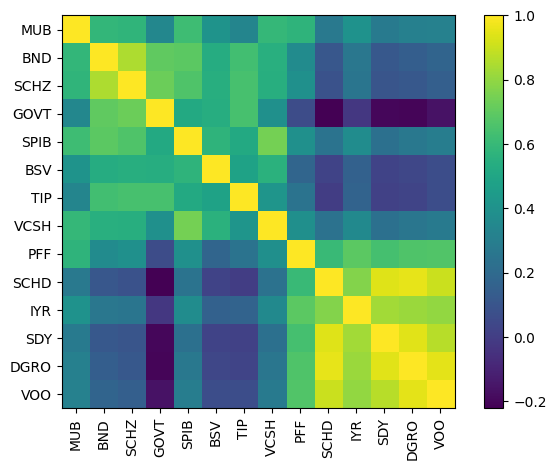

In [28]:
plotting.plot_covariance(S, plot_correlation=True);

In [29]:
market_prior = black_litterman.market_implied_prior_returns(caps_dict, delta, S)
market_prior

Ticker
MUB     0.031522
BND     0.029227
SCHZ    0.028196
GOVT    0.018681
SPIB    0.030747
BSV     0.022597
TIP     0.025412
VCSH    0.027997
PFF     0.071950
SCHD    0.098156
IYR     0.107440
SDY     0.099785
DGRO    0.101901
VOO     0.108654
dtype: float64

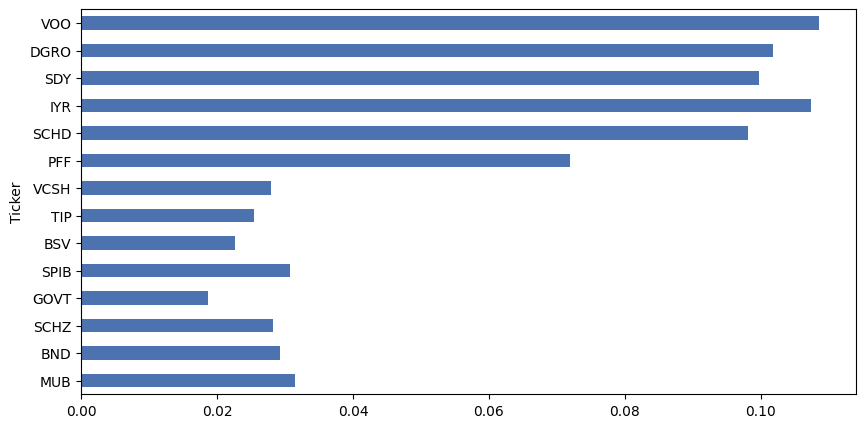

In [30]:
market_prior.plot.barh(figsize=(10,5));

In [31]:
last_row = filtered_df.iloc[-1]
sorted_target = target_series.reindex(last_row.index)
expt_returns = (sorted_target - last_row) / last_row
expt_returns.to_dict()

{'MUB': 0.03820674894159722,
 'BND': 0.09148918965600983,
 'SCHZ': 1.2105102152525642,
 'GOVT': 0.10563649218811108,
 'SPIB': 0.1002774972267034,
 'BSV': 0.06096253677844747,
 'TIP': 0.11551213920539875,
 'VCSH': 0.06791353001786954,
 'PFF': 0.05663068041245646,
 'SCHD': 2.3029431704837013,
 'IYR': -0.1817654844574291,
 'SDY': -0.00298554730414418,
 'DGRO': 0.13314546574323213,
 'VOO': 0.24528734081504847}

In [32]:
viewdict = expt_returns
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

In [33]:
def calculate_confidence(views):
    if abs(views) > 0.3:
        return random.choice([0.7, 0.8, 0.9])
    elif abs(views) > 0.1:
        return random.choice([0.4, 0.5, 0.6])
    else:
        return random.choice([0.1, 0.2, 0.3])
    
confidences = {ticker: calculate_confidence(return_value) for ticker, return_value in viewdict.items()}
confidences = list(confidences.values())
print(confidences)

[0.2, 0.1, 0.8, 0.6, 0.6, 0.3, 0.6, 0.1, 0.1, 0.8, 0.4, 0.3, 0.5, 0.4]


In [34]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

In [36]:
np.diag(bl.omega)

array([8.40017050e-04, 2.24676152e-03, 6.14728779e-05, 1.37438680e-04,
       1.27960217e-04, 1.54615279e-04, 1.80637541e-04, 1.07414217e-03,
       1.29001529e-02, 5.07467995e-04, 4.57080747e-03, 5.22253511e-03,
       2.04770802e-03, 3.37606055e-03])

In [37]:
intervals = []
for confidence in confidences:
    if confidence >= 0.7:
        interval = (confidence - 0.1, confidence + 0.1)
    elif 0.4 <= confidence <= 0.6:
        interval = (confidence - 0.05, confidence + 0.05)
    else:
        interval = (confidence - 0.03, confidence + 0.03)
    
    interval = (max(0, interval[0]), min(1, interval[1]))
    intervals.append(interval)

In [38]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.0009, 0.0009, 0.009999999999999995, 0.0025000000000000044, 0.0025000000000000044, 0.0008999999999999982, 0.0025000000000000044, 0.0009, 0.0009, 0.009999999999999995, 0.0024999999999999988, 0.0008999999999999982, 0.002500000000000002, 0.0024999999999999988]


In [39]:
bl = BlackLittermanModel(S, pi="market", market_caps=caps_dict, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [40]:
ret_bl = bl.bl_returns()
ret_bl

Ticker
MUB     0.033607
BND     0.051498
SCHZ    0.049953
GOVT    0.026800
SPIB    0.044457
BSV     0.018245
TIP     0.037553
VCSH    0.030606
PFF     0.072501
SCHD    0.155266
IYR     0.058711
SDY     0.103229
DGRO    0.136810
VOO     0.156073
dtype: float64

In [41]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
Ticker,,,
MUB,0.031522,0.033607,0.038207
BND,0.029227,0.051498,0.091489
SCHZ,0.028196,0.049953,1.210510
GOVT,0.018681,0.026800,0.105636
SPIB,0.030747,0.044457,0.100277
BSV,0.022597,0.018245,0.060963
TIP,0.025412,0.037553,0.115512
VCSH,0.027997,0.030606,0.067914
PFF,0.071950,0.072501,0.056631


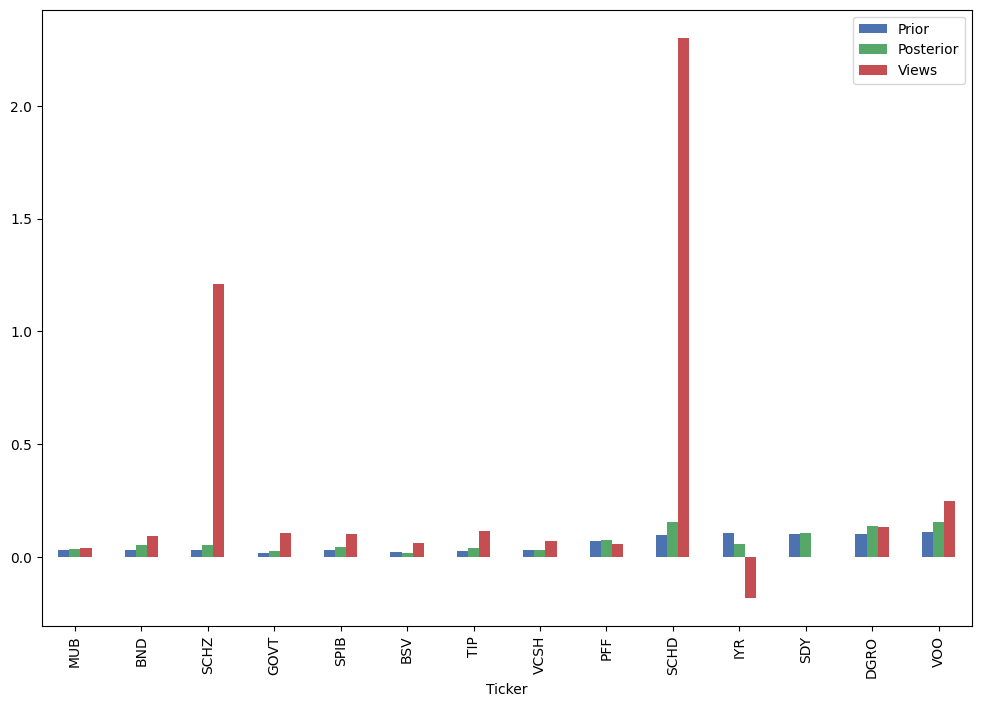

In [42]:
rets_df.plot.bar(figsize=(12,8));

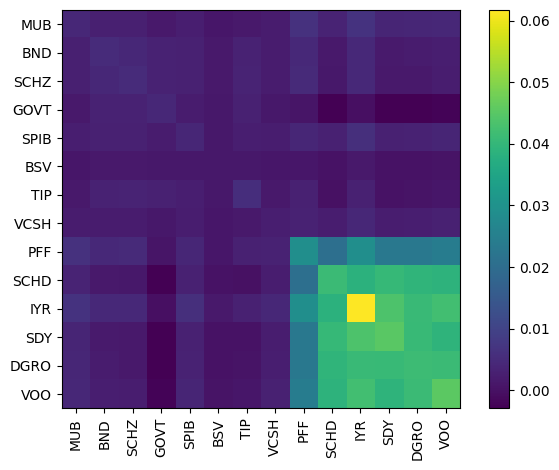

In [ ]:
S_bl = bl.bl_cov()

In [44]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_constraint(lambda w: w >= 0.0)
ef.add_constraint(lambda w: w <= 0.10)
bond_etfs = [0, 1, 2, 3, 4, 5, 6, 7]
stock_etfs = [8, 9, 10, 11, 12, 13]
ef.add_constraint(lambda w: sum(w[i] for i in bond_etfs) >= 0.6)
ef.add_constraint(lambda w: sum(w[i] for i in stock_etfs) <= 0.3)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

OrderedDict([('MUB', 0.08692),
             ('BND', 0.1),
             ('SCHZ', 0.1),
             ('GOVT', 0.07601),
             ('SPIB', 0.1),
             ('BSV', 0.06003),
             ('TIP', 0.09496),
             ('VCSH', 0.08208),
             ('PFF', 0.0),
             ('SCHD', 0.1),
             ('IYR', 0.0),
             ('SDY', 0.01867),
             ('DGRO', 0.08133),
             ('VOO', 0.1)])

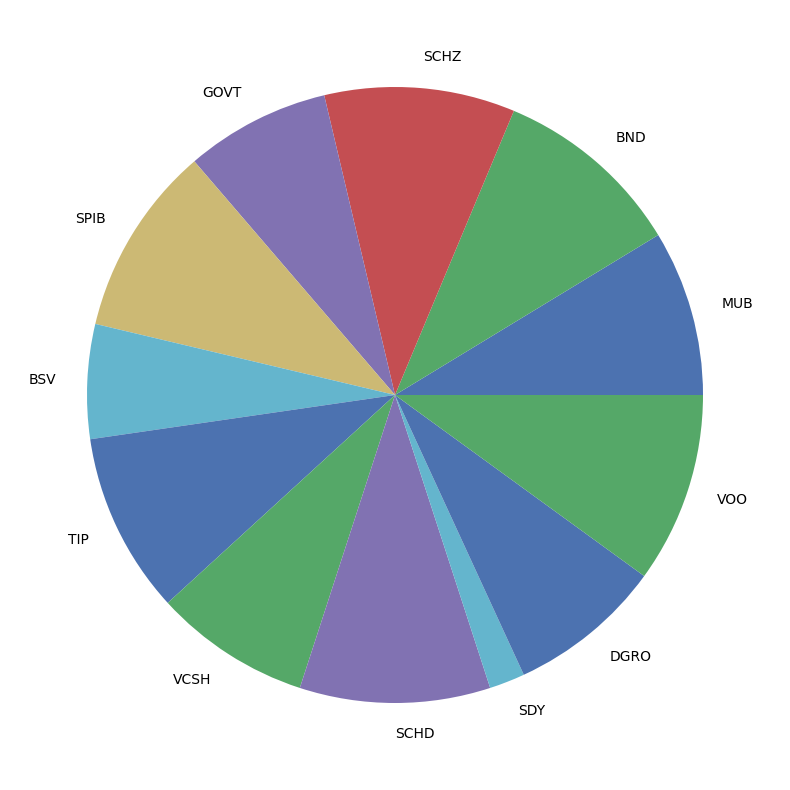

In [45]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [46]:
da = DiscreteAllocation(weights, filtered_df.iloc[-1], total_portfolio_value=400000)
alloc, leftover = da.greedy_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $9.63


{'BND': 562,
 'SCHZ': 1806,
 'SPIB': 1268,
 'SCHD': 1588,
 'VOO': 93,
 'TIP': 362,
 'MUB': 329,
 'VCSH': 439,
 'DGRO': 614,
 'GOVT': 1358,
 'BSV': 321,
 'SDY': 61}

# Portfolio Theory

In [47]:
stock_list = list(weights.keys())
stock_weights = list(weights.values())
portfolio = filtered_df[stock_list]
portfolio = np.log(portfolio / portfolio.shift(1))
portfolio.dropna(inplace=True)
portfolio

Ticker,MUB,BND,SCHZ,GOVT,SPIB,BSV,TIP,VCSH,PFF,SCHD,IYR,SDY,DGRO,VOO
Date,,,,,,,,,,,,,,
2019-01-03,0.002839,0.003899,0.003936,0.005618,0.002718,0.002286,0.005818,0.001921,0.001735,-0.019781,0.006390,-0.012676,-0.023832,-0.024160
2019-01-04,-0.002656,-0.003017,-0.003739,-0.005216,-0.002718,-0.002541,-0.002087,-0.002691,0.010634,0.027205,0.010649,0.022969,0.029252,0.032474
2019-01-07,-0.000092,-0.001512,-0.000789,-0.002013,-0.000605,-0.001146,-0.000636,-0.000385,0.003140,0.006740,0.010006,0.003999,0.004195,0.007475
2019-01-08,-0.000734,-0.001261,0.000000,-0.002017,0.000000,-0.000891,0.000818,-0.000514,0.002561,0.009402,0.018023,0.012340,0.008635,0.009668
2019-01-09,-0.001102,0.001388,-0.000198,0.000000,0.002418,0.000891,0.001180,0.002181,-0.001992,0.000831,-0.001305,0.001313,0.002665,0.004610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.000831,-0.000668,-0.000645,-0.000870,0.000611,0.000715,-0.001953,0.000532,0.001282,0.006083,0.003310,0.004114,0.003368,0.002323
2023-12-26,0.000369,0.000954,0.001075,0.000870,0.000306,-0.000650,0.000558,0.000000,0.000640,0.004866,0.007572,0.004979,0.004845,0.004150
2023-12-27,0.004054,0.006380,0.006212,0.005636,0.004571,0.002600,0.004549,0.002071,0.004789,0.000787,0.005234,0.001841,0.001486,0.001828


In [ ]:
weights_series = pd.Series(weights)
weighted_returns = portfolio.mul(weights_series, axis=1)
portfolio_returns = weighted_returns.sum(axis=1)

In [50]:
def get_factors(factors):
    factor_file = factors + ".csv"
    factor_df = pd.read_csv(factor_file)

    # Rename the first column to 'Date'
    factor_df = factor_df.rename(columns={'Unnamed: 0': 'Date'})

    # Check if the date format is monthly or daily
    if len(str(factor_df['Date'].iloc[0])) == 6:  # YYYYMM format (monthly)
        # Convert the date to YYYY-MM format
        factor_df['Date'] = factor_df['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m').strftime('%Y-%m'))
    else:  # Assuming YYYYMMDD format (daily)
        factor_df['Date'] = factor_df['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

    # Set the 'Date' column as the index
    factor_df = factor_df.set_index('Date')

    return factor_df

In [51]:
ff_factors_monthly = get_factors("F-F_Research_Data_Factors_daily")
ff_factors_monthly.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-01,0.10,-0.25,-0.27,0.009
1926-07-02,0.45,-0.33,-0.06,0.009
1926-07-06,0.17,0.30,-0.39,0.009
1926-07-07,0.09,-0.58,0.02,0.009
1926-07-08,0.21,-0.38,0.19,0.009


In [52]:
ff_factors_subset = ff_factors_monthly[
    ff_factors_monthly.index.isin(portfolio_returns.index)
].copy()

# Step 3: Calculate excess returns for the asset
ff_factors_subset["Excess_Return"] = portfolio_returns - ff_factors_subset["RF"]
ff_factors_subset

,Mkt-RF,SMB,HML,RF,Excess_Return
Date,,,,,
2019-01-03,-2.45,0.36,1.20,0.010,-0.013992
2019-01-04,3.55,0.41,-0.70,0.010,-0.003371
2019-01-07,0.94,1.00,-0.75,0.010,-0.008775
2019-01-08,1.01,0.53,-0.63,0.010,-0.007522
2019-01-09,0.56,0.45,0.10,0.010,-0.008605
...,...,...,...,...,...
2023-12-22,0.20,0.64,0.10,0.021,-0.019972
2023-12-26,0.48,0.71,0.43,0.021,-0.019266
2023-12-27,0.16,0.14,0.10,0.021,-0.017328


In [53]:
X = sm.add_constant(ff_factors_subset[["Mkt-RF", "SMB", "HML"]])
y = ff_factors_subset["Excess_Return"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     126.8
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           1.02e-71
Time:                        23:59:27   Log-Likelihood:                 4339.9
No. Observations:                1257   AIC:                            -8672.
Df Residuals:                    1253   BIC:                            -8651.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0069      0.000    -31.921      0.0

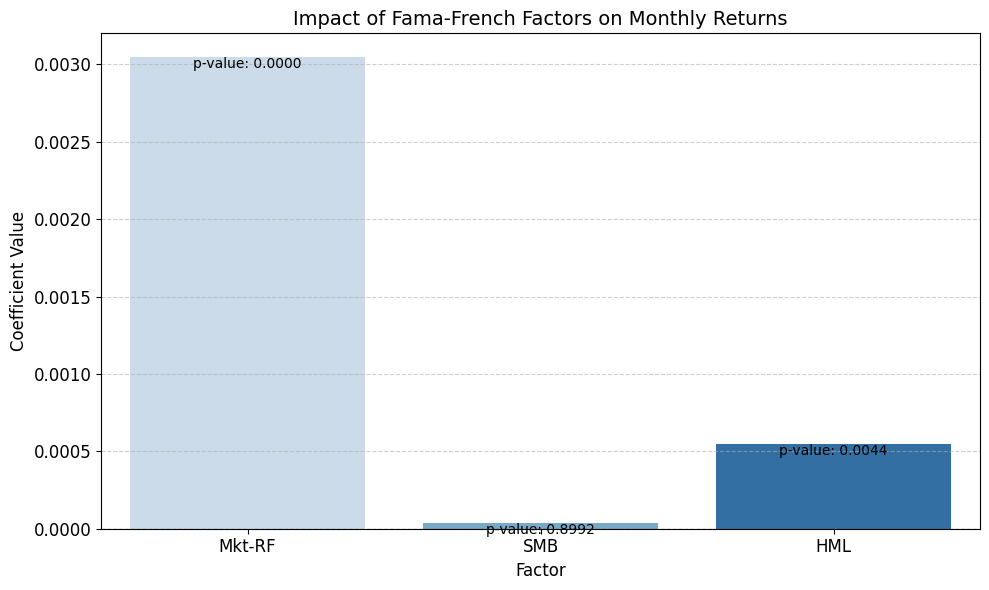

In [54]:
factors = model.params.index[1:]  # ['Mkt_Rf', 'SMB', 'HML']
coefficients = model.params.values[1:]
confidence_intervals = model.conf_int().diff(axis=1).iloc[1]

ols_data = pd.DataFrame(
    {
        "Factor": factors,
        "Coefficient": coefficients,
        "Confidence_Lower": confidence_intervals[0],
        "Confidence_Upper": confidence_intervals[1],
    }
)

plt.figure(figsize=(10, 6))

sns.barplot(x="Factor", y="Coefficient", data=ols_data, palette="Blues")

for i, row in ols_data.iterrows():
    plt.text(
        i,
        row['Coefficient'],
        f"p-value: {model.pvalues[row['Factor']]:.4f}",
        ha="center",
        va="top",
        fontsize=10,
        color="black",
    )

plt.title("Impact of Fama-French Factors on Monthly Returns", fontsize=14)
plt.xlabel("Factor", fontsize=12)
plt.ylabel("Coefficient Value", fontsize=12)

plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


# Scenario Analysis

In [ ]:
from dataclasses import dataclass
from sensitivity import SensitivityAnalyzer

In [56]:
@dataclass
class ModelInputs:
    starting_salary: int = 60000
    promos_every_n_years: int = 5
    cost_of_living_raise: float = 0.02
    promo_raise: float = 0.15
    savings_rate: float = 0.25
    interest_rate: float = 0.05
    desired_cash: int = 1500000
        
model_data = ModelInputs()
model_data

ModelInputs(starting_salary=60000, promos_every_n_years=5, cost_of_living_raise=0.02, promo_raise=0.15, savings_rate=0.25, interest_rate=0.05, desired_cash=1500000)

In [57]:
def salary_at_year(data: ModelInputs, year):
    """
    Gets the salary at a given year from the start of the model based on cost of living raises and regular promotions.
    """
    # Every n years we have a promotion, so dividing the years and taking out the decimals gets the number of promotions
    num_promos = int(year / data.promos_every_n_years)
    salary_t = data.starting_salary * (1 + data.cost_of_living_raise) ** year * (1 + data.promo_raise) ** num_promos
    return salary_t

In [58]:
for i in range(6):
    year = i + 1
    salary = salary_at_year(model_data, year)
    print(f'The salary at year {year} is ${salary:,.0f}.')

The salary at year 1 is $61,200.
The salary at year 2 is $62,424.
The salary at year 3 is $63,672.
The salary at year 4 is $64,946.
The salary at year 5 is $76,182.
The salary at year 6 is $77,705.


In [59]:
def cash_saved_during_year(data: ModelInputs, year):
    """
    Calculated the cash saved within a given year, by first calculating the salary at that year then applying the 
    savings rate.
    """
    salary = salary_at_year(data, year)
    cash_saved = salary * data.savings_rate
    return cash_saved

In [60]:
def wealth_at_year(data: ModelInputs, year, prior_wealth):
    """
    Calculate the accumulated wealth for a given year, based on previous wealth, the investment rate,
    and cash saved during the year.
    """
    cash_saved = cash_saved_during_year(data, year)
    wealth = prior_wealth * (1 + data.interest_rate) + cash_saved
    return wealth

In [61]:
prior_wealth = 0  # starting with no cash saved
for i in range(6):
    year = i + 1
    wealth = wealth_at_year(model_data, year, prior_wealth)
    print(f'The wealth at year {year} is ${wealth:,.0f}.')
    
    # Set next year's prior wealth to this year's wealth
    prior_wealth = wealth

The wealth at year 1 is $15,300.
The wealth at year 2 is $31,671.
The wealth at year 3 is $49,173.
The wealth at year 4 is $67,868.
The wealth at year 5 is $90,307.
The wealth at year 6 is $114,248.


In [62]:
def years_to_retirement(data: ModelInputs, print_output=True):
    
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    
    year = 0
    
    if print_output:
        print('Wealths over time:')
    while wealth < data.desired_cash:
        year = year + 1
        wealth = wealth_at_year(data, year, prior_wealth)
        if print_output:
            print(f'The wealth at year {year} is ${wealth:,.0f}.')

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        
    # Now we have exited the while loop, so wealth must be >= desired_cash. Whatever last year was set
    # is the years to retirement.
    if print_output:
        print(f'\nRetirement:\nIt will take {year} years to retire.')  # \n makes a blank line in the output.
    return year

In [63]:
years = years_to_retirement(model_data)

Wealths over time:
The wealth at year 1 is $15,300.
The wealth at year 2 is $31,671.
The wealth at year 3 is $49,173.
The wealth at year 4 is $67,868.
The wealth at year 5 is $90,307.
The wealth at year 6 is $114,248.
The wealth at year 7 is $139,775.
The wealth at year 8 is $166,975.
The wealth at year 9 is $195,939.
The wealth at year 10 is $229,918.
The wealth at year 11 is $266,080.
The wealth at year 12 is $304,542.
The wealth at year 13 is $345,431.
The wealth at year 14 is $388,878.
The wealth at year 15 is $439,025.
The wealth at year 16 is $492,294.
The wealth at year 17 is $548,853.
The wealth at year 18 is $608,878.
The wealth at year 19 is $672,557.
The wealth at year 20 is $745,168.
The wealth at year 21 is $822,190.
The wealth at year 22 is $903,859.
The wealth at year 23 is $990,422.
The wealth at year 24 is $1,082,140.
The wealth at year 25 is $1,185,745.
The wealth at year 26 is $1,295,520.
The wealth at year 27 is $1,411,793.
The wealth at year 28 is $1,534,910.

Reti

In [64]:
def get_salaries_wealths_df(data):
    """
    Runs the retirement model, collecting salary and wealth information year by year and storing
    into a DataFrame for further analysis.
    """
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    
    year = 0
    
    df_data_tups = []
    while wealth < data.desired_cash:
        year = year + 1
        salary = salary_at_year(data, year)
        wealth = wealth_at_year(data, year, prior_wealth)

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        df_data_tups.append((year, salary, wealth))
        
    df = pd.DataFrame(df_data_tups, columns=['Year', 'Salary', 'Wealth'])
    
    return df

In [65]:
def styled_salaries_wealths(df):
    return df.style.format({
        'Salary': '${:,.2f}',
        'Wealth': '${:,.2f}'
    })

In [66]:
df = get_salaries_wealths_df(model_data)
styled_salaries_wealths(df)

,Year,Salary,Wealth
0,1,"$61,200.00","$15,300.00"
1,2,"$62,424.00","$31,671.00"
2,3,"$63,672.48","$49,172.67"
3,4,"$64,945.93","$67,867.79"
4,5,"$76,181.58","$90,306.57"
5,6,"$77,705.21","$114,248.20"
6,7,"$79,259.31","$139,775.44"
7,8,"$80,844.50","$166,975.33"
8,9,"$82,461.39","$195,939.45"
9,10,"$96,727.21","$229,918.22"


<Axes: xlabel='Year'>

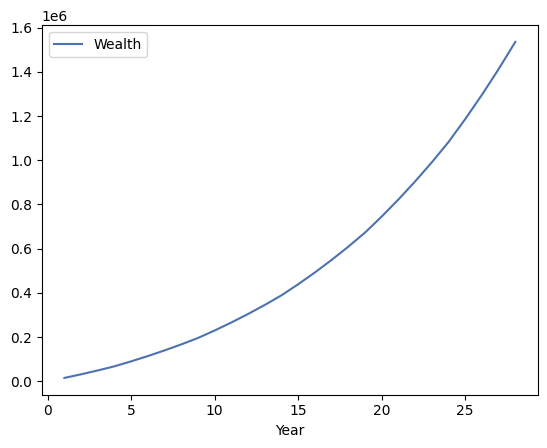

In [67]:
df.plot.line(x='Year', y='Wealth')

<Axes: xlabel='Year'>

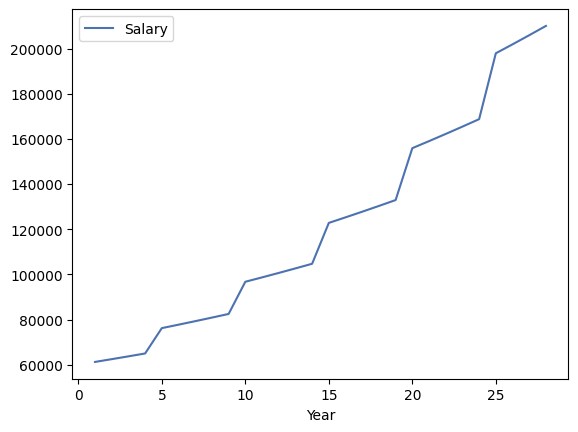

In [68]:
df.plot.line(x='Year', y='Salary')

In [69]:
def years_to_retirement_separate_args(
    starting_salary=60000, promos_every_n_years=5, cost_of_living_raise=0.02, 
    promo_raise=0.15, savings_rate=0.25, interest_rate=0.05, desired_cash=1500000
):
    data = ModelInputs(
        starting_salary=starting_salary, 
        promos_every_n_years=promos_every_n_years, 
        cost_of_living_raise=cost_of_living_raise, 
        promo_raise=promo_raise, 
        savings_rate=savings_rate, 
        interest_rate=interest_rate, 
        desired_cash=desired_cash
    )
    
    return years_to_retirement(data, print_output=False)

years_to_retirement_separate_args()

28

In [70]:
sensitivity_values = {
    'starting_salary': [i * 10000 for i in range(4, 8)],
    'promos_every_n_years': [i for i in range(4, 8)],
    'cost_of_living_raise': [i/100 for i in range(1, 4)],
    'promo_raise': [i/100 for i in range(10, 25, 5)],
    'savings_rate': [i/100 for i in range(10, 50, 10)],
    'interest_rate': [i/100 for i in range(3, 8)],
    'desired_cash': [i * 100000 for i in range(10, 26, 5)]
}

In [71]:
sa = SensitivityAnalyzer(
    sensitivity_values,
    years_to_retirement_separate_args,
    result_name='Years to Retirement',
    reverse_colors=True,
    grid_size=3
)

100%|██████████| 11520/11520 [00:07<00:00, 1529.40it/s]


In [72]:
sa.df

,starting_salary,promos_every_n_years,cost_of_living_raise,promo_raise,savings_rate,interest_rate,desired_cash,Years to Retirement
0,40000,4,0.01,0.1,0.1,0.03,1000000,52
1,40000,4,0.01,0.1,0.1,0.03,1500000,60
2,40000,4,0.01,0.1,0.1,0.03,2000000,66
3,40000,4,0.01,0.1,0.1,0.03,2500000,71
4,40000,4,0.01,0.1,0.1,0.04,1000000,47
...,...,...,...,...,...,...,...,...
11515,70000,7,0.03,0.2,0.4,0.06,2500000,25
11516,70000,7,0.03,0.2,0.4,0.07,1000000,16
11517,70000,7,0.03,0.2,0.4,0.07,1500000,19
11518,70000,7,0.03,0.2,0.4,0.07,2000000,22


In [73]:
bad_economy_data = ModelInputs(
    starting_salary=40000,
    promos_every_n_years=8,
    cost_of_living_raise=0.01,
    promo_raise=0.07,
    savings_rate=0.15,
    interest_rate=0.03,
)

good_economy_data = ModelInputs(
    starting_salary=70000,
    promos_every_n_years=4,
    cost_of_living_raise=0.03,
    promo_raise=0.20,
    savings_rate=0.35,
    interest_rate=0.06,
)

cases = {
    'Bad': bad_economy_data,
    'Normal': model_data, # Original inputs were set to assume a normal economy
    'Good': good_economy_data
}

In [74]:
for case_type, case_inputs in cases.items():
    ytr = years_to_retirement(case_inputs, print_output=False)
    print(f'It would take {ytr} years to retire in a {case_type} economy.')

It would take 61 years to retire in a Bad economy.
It would take 28 years to retire in a Normal economy.
It would take 19 years to retire in a Good economy.


In [75]:
case_probabilities = {
    'Bad': 0.2,
    'Normal': 0.5,
    'Good': 0.3
}

# Take expected value over the cases
expected_ytr = 0
for case_type, case_inputs in cases.items():
    ytr = years_to_retirement(case_inputs, print_output=False)
    weighted_ytr = ytr * case_probabilities[case_type]
    expected_ytr += weighted_ytr
print(f'It would take {expected_ytr:.0f} years to retire considering a {case_probabilities["Bad"]:.0%} chance of a bad economy and {case_probabilities["Good"]:.0%} chance of a good economy.')

It would take 32 years to retire considering a 20% chance of a bad economy and 30% chance of a good economy.


# Evaluation

In [56]:
list(portfolio.columns)

['MUB',
 'BND',
 'SCHZ',
 'GOVT',
 'SPIB',
 'BSV',
 'TIP',
 'VCSH',
 'PFF',
 'SCHD',
 'IYR',
 'SDY',
 'DGRO',
 'VOO']

In [57]:
port_data = {}
start_date = '2023-12-31'
end_date = '2024-11-26'

for ticker in portfolio.columns:
    print(f"Fetching data for ticker: {ticker}")
    port_data[ticker] = yfinance_adj_close(ticker, start=start_date, end=end_date)

portfolio_df = pd.concat(port_data.values(), axis=1)
portfolio_df.ffill(inplace=True)
portfolio_df.bfill(inplace=True)
portfolio_df.columns = portfolio.columns
portfolio_df

Fetching data for ticker: MUB
Fetching data for ['MUB'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: BND
Fetching data for ['BND'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: SCHZ
Fetching data for ['SCHZ'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: GOVT
Fetching data for ['GOVT'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: SPIB
Fetching data for ['SPIB'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: BSV
Fetching data for ['BSV'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: TIP
Fetching data for ['TIP'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: VCSH
Fetching data for ['VCSH'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: PFF
Fetching data for ['PFF'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: SCHD
Fetching data for ['SCHD'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: IYR
Fetching data for ['IYR'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: SDY
Fetching data for ['SDY'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: DGRO
Fetching data for ['DGRO'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: VOO
Fetching data for ['VOO'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Ticker,MUB,BND,SCHZ,GOVT,SPIB,BSV,TIP,VCSH,PFF,SCHD,IYR,SDY,DGRO,VOO
Date,,,,,,,,,,,,,,
2024-01-02,105.606331,71.075073,22.183380,22.378719,31.538450,74.734299,105.011169,74.698166,29.590870,25.070749,90.660507,123.267540,53.071957,429.748047
2024-01-03,105.655098,71.133293,22.212059,22.417688,31.519176,74.753761,105.177475,74.649788,29.600367,24.913834,88.497711,122.039581,52.786839,426.559662
2024-01-04,105.557541,70.813049,22.111685,22.310516,31.432421,74.656502,104.688332,74.591728,29.562372,24.884411,88.340416,121.803810,52.757339,425.213013
2024-01-05,105.420982,70.599556,22.049545,22.242321,31.384228,74.598145,104.453529,74.533646,29.562372,24.966139,88.143799,121.911865,52.777004,425.757660
2024-01-08,105.791656,70.910088,22.140362,22.310516,31.470984,74.714859,104.737244,74.669136,29.837856,25.113249,89.411980,122.766525,53.180107,431.847260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-19,107.589996,72.680000,22.969999,22.680000,33.000000,77.410004,107.879997,78.260002,32.509998,28.639999,99.120003,139.720001,63.000000,542.700012
2024-11-20,107.589996,72.599998,22.930000,22.650000,32.950001,77.360001,107.830002,78.220001,32.349998,28.709999,98.910004,139.619995,63.040001,542.900024
2024-11-21,107.540001,72.559998,22.920000,22.629999,32.930000,77.309998,107.690002,78.169998,32.639999,28.980000,99.620003,141.279999,63.770000,545.640015


In [58]:
returns_df = portfolio_df.pct_change().dropna()
port_retss = returns_df.sum(axis=1)

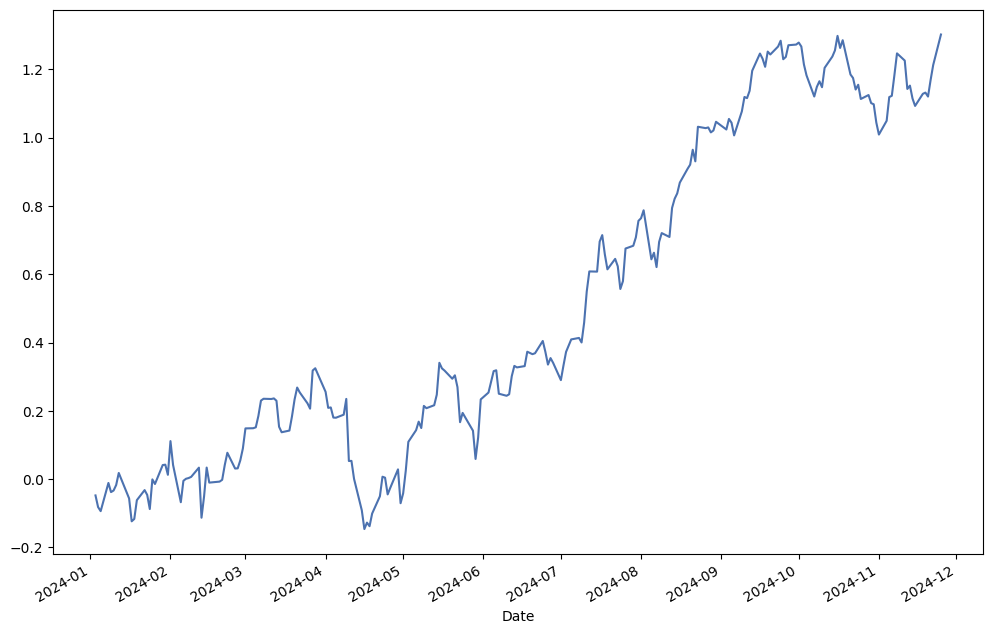

In [59]:
port_retss.cumsum().plot(figsize=(12,8));

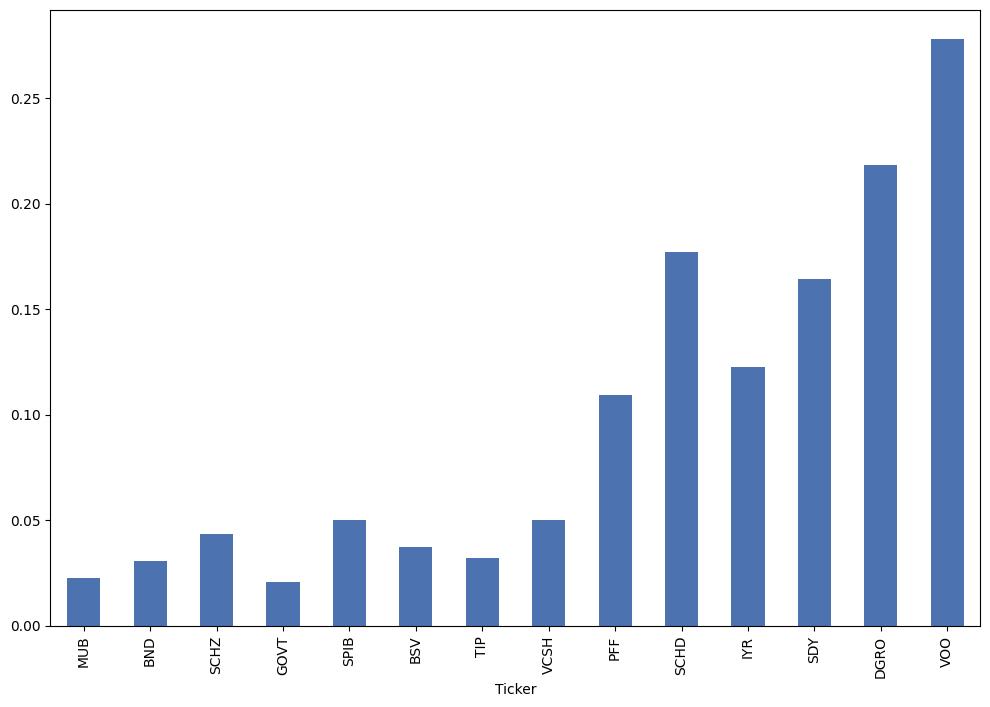

In [60]:
cumulative_returns_df = (1 + returns_df).prod() - 1
cumulative_returns_df.plot(kind='bar', figsize=(12,8));

In [61]:
ticker = "^IRX"

start_date = "2022-01-01"
end_date = "2024-11-26"

rf = yf.download(ticker, start=start_date, end=end_date)
rf = rf[['Adj Close']]
rf = rf.rename(columns={'Adj Close': 'rf'})
rolling_rf = rf.rolling(window=252).mean()
rolling_rf

[*********************100%%**********************]  1 of 1 completed


,rf
Date,
2022-01-03,NaN
2022-01-04,NaN
2022-01-05,NaN
2022-01-06,NaN
2022-01-07,NaN
...,...
2024-11-19,5.058925
2024-11-20,5.055639
2024-11-21,5.052298


In [62]:
rolling_rf.iloc[-1].values

array([5.0455595])

[*********************100%%**********************]  1 of 1 completed

Portfolio Performance Metrics:
Annualized Sharpe Ratio: 1.01
Annualized Jensen Alpha: 3.07%

Attribution Analysis:
Allocation Effects: 0.04%
Selection Effects: 9.62%


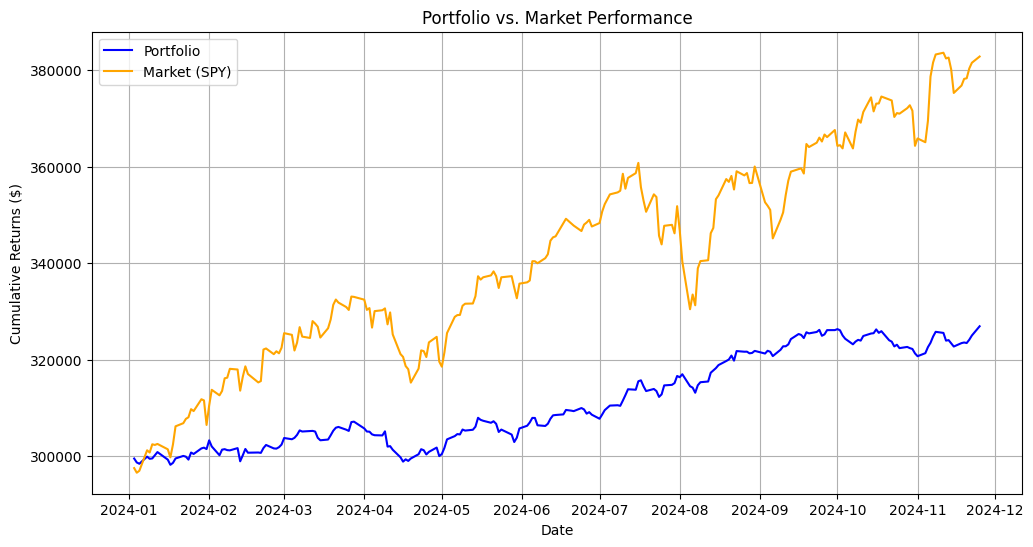

In [63]:
start_date = '2023-12-31'
end_date = '2024-11-26'
# Market data (e.g., S&P 500 as market benchmark)
market_prices = yf.download("SPY", start=start_date, end=end_date)["Adj Close"]

# Portfolio returns (weighted daily returns based on portfolio_df and stock_weights)
port_retss = (portfolio_df.pct_change() @ stock_weights).dropna()  # Weighted daily returns

# Initial money
initial_money = 300000

# Constants
trading_days_per_year = 252
risk_free_rate_annual = (rolling_rf.iloc[-1].values)/100  # 2% annual risk-free rate

# Step 1: Calculate cumulative portfolio returns starting from initial money
portfolio_cum_returns = (1 + port_retss).cumprod() * initial_money  # Adjust cumulative returns

# Step 2: Calculate market returns
market_returns = market_prices.pct_change().dropna()

# Step 3: Sharpe Ratio (Annualized)
risk_free_rate_daily = risk_free_rate_annual / trading_days_per_year
excess_returns = port_retss - risk_free_rate_daily
sharpe_ratio = (excess_returns.mean() * trading_days_per_year) / (port_retss.std() * np.sqrt(trading_days_per_year))

# Step 4: Jensen's Alpha (Annualized)
slope, intercept, _, _, _ = linregress(market_returns, port_retss)
jensen_alpha_daily = intercept
jensen_alpha = jensen_alpha_daily * trading_days_per_year

# Step 5: Attribution Analysis
allocation_effects = portfolio_df.pct_change().mean() * stock_weights
selection_effects = port_retss.mean() * trading_days_per_year - allocation_effects.sum()

# Display Results
print("Portfolio Performance Metrics:")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Annualized Jensen Alpha: {jensen_alpha:.2%}")

print("\nAttribution Analysis:")
print(f"Allocation Effects: {allocation_effects.sum():.2%}")
print(f"Selection Effects: {selection_effects:.2%}")

# Step 6: Plot Portfolio vs. Market
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cum_returns, label="Portfolio", color="blue")
plt.plot((1 + market_returns).cumprod() * initial_money, label="Market (SPY)", color="orange")  # Adjusted market cumulative returns
plt.legend()
plt.title("Portfolio vs. Market Performance")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns ($)")
plt.grid()
plt.show()

In [64]:
beta, _, _, _, _ = linregress(market_returns, port_retss)
print(f"Beta: {beta:.2f}")

Beta: 0.24


In [65]:
rolling_max = portfolio_cum_returns.cummax()
drawdown = (portfolio_cum_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")

Maximum Drawdown: -2.70%


In [66]:
downside_returns = port_retss[port_retss < 0]
sortino_ratio = excess_returns.mean() / downside_returns.std()
print(f"Sortino Ratio: {sortino_ratio:.2f}")

Sortino Ratio: 0.09


In [67]:
annualized_return = (portfolio_cum_returns.iloc[-1] / portfolio_cum_returns.iloc[0]) ** (252 / len(portfolio_returns)) - 1
print(f"Annualized Return: {annualized_return:.2%}")

Annualized Return: 1.77%


In [68]:
correlation = port_retss.corr(market_returns)
print(f"Correlation with Market: {correlation:.2f}")

Correlation with Market: 0.64


In [69]:
portfolio_volatility = port_retss.std() * (252 ** 0.5)  # Annualized volatility
print(f"Portfolio Volatility: {portfolio_volatility:.2%}")

Portfolio Volatility: 4.57%


In [70]:
treynor_ratio = excess_returns.mean() / beta
print(f"Treynor Ratio: {treynor_ratio:.2f}")

Treynor Ratio: 0.00


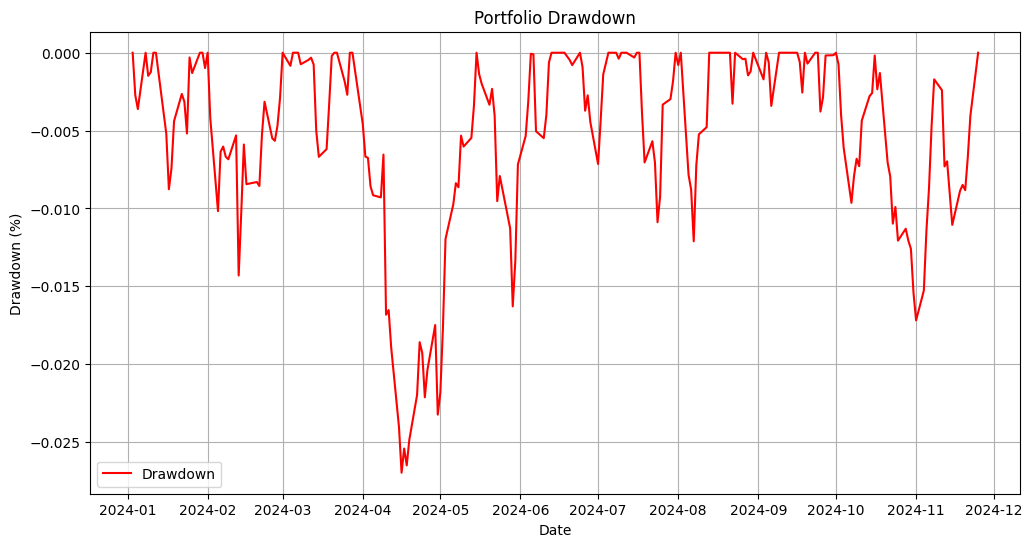

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(drawdown, label="Drawdown", color="red")
plt.title("Portfolio Drawdown")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.grid()
plt.legend()
plt.show()